# **CycleGAN Monet-to-Photo**

![image](https://miro.medium.com/max/1838/0*S5gn5i6UhfyoRr9S.png)

# Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Weight Setting
Step 9. Configure Optimizer
Step 10. Learning Rate Scheduler Setting
Step 11. Image Transformation Setting
Step 12. DataLoader Setting
Step 13. Define function to get sample images
Step 14. Training
```
---

# Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Step 2. Initial Setting

In [2]:
# data (path)
dataset_name = 'gan-getting-started'
root = '../input/'+dataset_name

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay


# Step 3. Define Generator

In [3]:
import torch
import torch.nn as nn

class ResidualBlockImproved(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlockImproved, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),  # Use InstanceNorm2d for style transfer tasks
            nn.GELU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)  # Residual connection


class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        # Compute query, key, and value projections
        proj_query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # (B, N, C//8)
        proj_key = self.key(x).view(batch_size, -1, width * height)  # (B, C//8, N)
        attention = torch.bmm(proj_query, proj_key)  # (B, N, N)
        attention = nn.Softmax(dim=-1)(attention)  # Normalize attention weights

        proj_value = self.value(x).view(batch_size, -1, width * height)  # (B, C, N)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # (B, C, N)
        out = out.view(batch_size, C, width, height)  # Reshape to original dimensions

        return self.gamma * out + x  # Apply residual connection


class GeneratorResNetImproved(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNetImproved, self).__init__()
        channels = input_shape[0]
        out_features = 64

        # Initial Convolution Block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.GELU()
        ]

        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.GELU()
            ]
            in_features = out_features

        # Residual Blocks with Self-Attention
        for i in range(num_residual_blocks):
            model += [ResidualBlockImproved(out_features)]
            if i % 2 == 0:  # Apply Self-Attention every other block
                model += [SelfAttention(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2, mode='nearest'),  # Stable upsampling
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.GELU()
            ]
            in_features = out_features

        # Output Layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(out_features, channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# Step 4. Define Discriminator

In [4]:
import torch
import torch.nn as nn

class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_shape):
        super(ImprovedDiscriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of the image discriminator
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)
        
        # Define the discriminator block with spectral normalization
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers with optional normalization and spectral normalization"""
            layers = [nn.utils.spectral_norm(nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1))]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),  # No normalization for the first layer
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, padding=1))
        )
        
    def forward(self, img):
        return self.model(img)


# Step 5. Define Loss

In [5]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Step 6. Initialize Generator and Discriminator

In [6]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNetImproved (input_shape, n_residual_blocks)
G_BA = GeneratorResNetImproved (input_shape, n_residual_blocks)
D_A = ImprovedDiscriminator(input_shape)
D_B = ImprovedDiscriminator(input_shape)

# Step 7. GPU Setting

In [7]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Step 8. Weight Setting

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [9]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

ImprovedDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

# Step 9. Configure Optimizers

In [10]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

# Step 10. Learning Rate Scheduler Setting

In [11]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [12]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

# Step 11. Image Transformation Setting

In [13]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

# Step 12. DataLoader Setting

In [14]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [15]:
import os
import glob

In [16]:
print(root+'/monet_jpg')

../input/gan-getting-started/monet_jpg


In [17]:
len(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*'))

300

In [18]:
len(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*'))

7038

In [19]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[250:])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

In [20]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=16, # 3
    pin_memory=True
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=3
)

# Step 13. Define function to get sample images

In [21]:
import matplotlib.pyplot as plt

In [22]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [23]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

# Step 14. Training

In [24]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

from tqdm import tqdm
import torch
import numpy as np

# Ensure all tensors and models are on the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1/5:  80%|███████▉  | 199/250 [18:07<04:38,  5.46s/it]

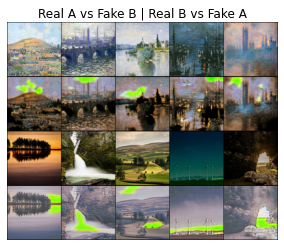

Epoch 1/5:  80%|████████  | 200/250 [18:13<04:47,  5.76s/it]

[Epoch 1/5] [Batch 200/250] [D loss: 0.223920] [G loss: 3.276999 (adv: 0.314558, cycle: 0.197942, identity: 0.196604)]


Epoch 2/5:  80%|███████▉  | 199/250 [18:06<04:38,  5.46s/it]

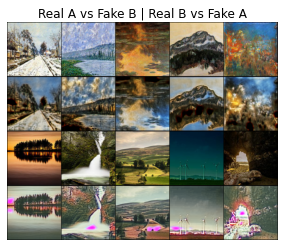

Epoch 2/5:  80%|████████  | 200/250 [18:12<04:47,  5.75s/it]

[Epoch 2/5] [Batch 200/250] [D loss: 0.193341] [G loss: 2.578908 (adv: 0.438052, cycle: 0.149845, identity: 0.128481)]


Epoch 3/5:  80%|███████▉  | 199/250 [18:06<04:38,  5.46s/it]

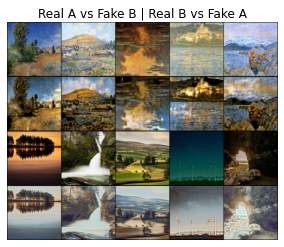

Epoch 3/5:  80%|████████  | 200/250 [18:12<04:47,  5.74s/it]

[Epoch 3/5] [Batch 200/250] [D loss: 0.127398] [G loss: 3.618535 (adv: 0.476827, cycle: 0.204987, identity: 0.218368)]


Epoch 4/5:  80%|███████▉  | 199/250 [18:06<04:38,  5.46s/it]

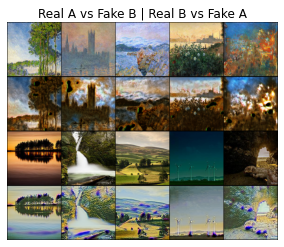

Epoch 4/5:  80%|████████  | 200/250 [18:12<04:47,  5.75s/it]

[Epoch 4/5] [Batch 200/250] [D loss: 0.141862] [G loss: 3.478323 (adv: 0.604217, cycle: 0.188790, identity: 0.197240)]


Epoch 5/5:  80%|███████▉  | 199/250 [18:06<04:38,  5.46s/it]

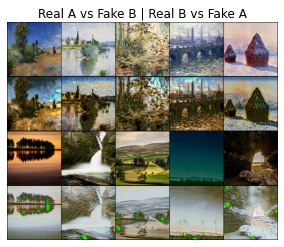

Epoch 5/5:  80%|████████  | 200/250 [18:12<04:46,  5.74s/it]

[Epoch 5/5] [Batch 200/250] [D loss: 0.153400] [G loss: 3.744415 (adv: 0.531046, cycle: 0.211341, identity: 0.219993)]


Epoch 5/5: 100%|██████████| 250/250 [22:45<00:00,  5.46s/it]


In [25]:
from tqdm import tqdm
import torch
import numpy as np
from torch.cuda.amp import autocast, GradScaler

# Ensure all tensors and models are on the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use mixed precision
scaler = GradScaler()

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")):
        
        # Set model input
        real_A = batch['A'].to(device).type(Tensor)
        real_B = batch['B'].to(device).type(Tensor)
        
        # Precompute adversarial ground truths
        batch_size = real_A.size(0)
        valid = Tensor(np.ones((batch_size, *D_A.output_shape))).to(device)
        fake = Tensor(np.zeros((batch_size, *D_A.output_shape))).to(device)
        
        # -----------------
        # Train Generators
        # -----------------
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        with autocast():  # Enable mixed precision
            # Identity Loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN Loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total Loss
            loss_G = loss_GAN + (10.0 * loss_cycle) + (5.0 * loss_identity)

        # Check for NaN or Inf in loss
        if torch.isnan(loss_G) or torch.isinf(loss_G):
            print(f"NaN or Inf detected in Generator Loss at Epoch {epoch+1}, Batch {i+1}. Skipping update.")
            continue

        scaler.scale(loss_G).backward()  # Scale loss for mixed precision

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(G_AB.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(G_BA.parameters(), max_norm=1.0)

        scaler.step(optimizer_G)
        scaler.update()
        
        # -----------------
        # Train Discriminator A
        # -----------------
        optimizer_D_A.zero_grad()
        with autocast():
            loss_real = criterion_GAN(D_A(real_A), valid)
            loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
            loss_D_A = (loss_real + loss_fake) / 2

        scaler.scale(loss_D_A).backward()
        scaler.step(optimizer_D_A)
        scaler.update()

        # -----------------
        # Train Discriminator B
        # -----------------
        optimizer_D_B.zero_grad()
        with autocast():
            loss_real = criterion_GAN(D_B(real_B), valid)
            loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
            loss_D_B = (loss_real + loss_fake) / 2

        scaler.scale(loss_D_B).backward()
        scaler.step(optimizer_D_B)
        scaler.update()
        
        # Total Discriminator Loss
        loss_D = (loss_D_A + loss_D_B) / 2
    
        # -----------------
        # Show Progress
        # -----------------
        if (i + 1) % 200 == 0:  # Log progress less frequently
            sample_images()
            print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(dataloader)}] "
                  f"[D loss: {loss_D.item():.6f}] [G loss: {loss_G.item():.6f} "
                  f"(adv: {loss_GAN.item():.6f}, cycle: {loss_cycle.item():.6f}, identity: {loss_identity.item():.6f})]")


In [26]:
from concurrent.futures import ThreadPoolExecutor
import cv2
import os
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

# Ensure your generator is loaded and set to evaluation mode
G_AB.eval()  # Put the generator in evaluation mode

# Define your DataLoader with optimizations
sub_dloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=16,  # Adjust batch size based on your GPU memory
    shuffle=False,
    num_workers=8,  # Use a high number for efficient data loading
    pin_memory=True,  # Enables faster data transfer to GPU
)

# Path to save the zip file
output_zip_path = './images.zip'

# Function to save an image directly into the zip file
def save_image_to_zip(img_array, zipf, img_name):
    _, img_encoded = cv2.imencode('.jpg', img_array)  # Encode as JPEG
    zipf.writestr(img_name, img_encoded.tobytes())    # Write to zip

# Generate and save images directly to the zip file
with zipfile.ZipFile(output_zip_path, 'w') as zipf:
    with ThreadPoolExecutor() as executor:
        for i, batch in tqdm(enumerate(sub_dloader), total=len(sub_dloader)):
            original_imgs = batch['A'].to(device)  # Assuming 'A' is the input images
            with torch.no_grad():  # Disable gradient calculation for inference
                predicted_imgs = G_AB(original_imgs)  # Generate the output images
                # Normalize and convert to numpy format
                predicted_imgs = (predicted_imgs * 127.5 + 127.5).clamp(0, 255).cpu().numpy()
                predicted_imgs = predicted_imgs.transpose(0, 2, 3, 1).astype('uint8')  # Convert to HWC format

                # Save each image directly into the zip file
                for j, img_array in enumerate(predicted_imgs):
                    img_name = f"monet_{i * 16 + j + 1}.jpg"  # Generate unique name
                    executor.submit(save_image_to_zip, img_array, zipf, img_name)

print(f"Generated images saved to {output_zip_path}")

100%|██████████| 425/425 [03:51<00:00,  1.84it/s]

Generated images saved to ./images.zip
